# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1401 (delta 1401), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 19.20 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ec9ff436510>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 73.3MB/s]


In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [9]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [10]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 16.413 seconds


### Make predictions on the entire test dataset with the model

In [11]:
# TODO
from tqdm.auto import tqdm
test_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    test_logit = model_0(X)
    test_pred = torch.softmax(test_logit, dim=1).argmax(dim=1)
    test_preds.append(test_pred.cpu())

test_preds = torch.cat(test_preds)
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [12]:
#Get the truth labels
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [13]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.4 MB/s eta 0:00:00
mlxtend version: 0.23.4


In [14]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


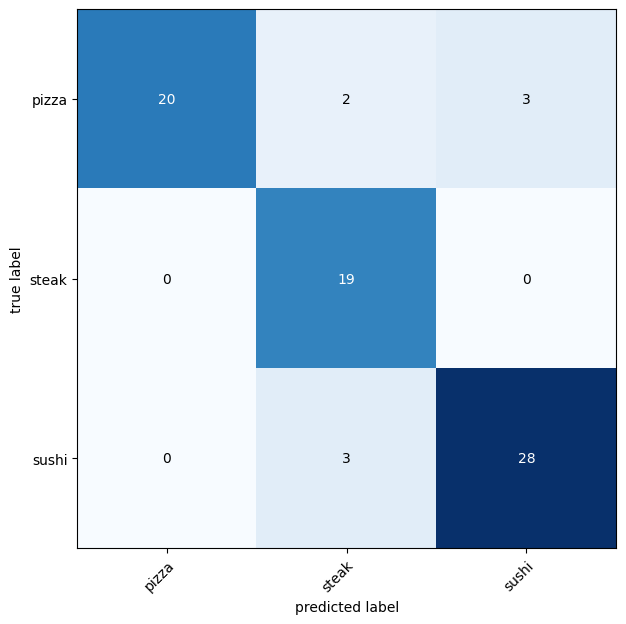

In [15]:
# TODO
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes = len(class_names), task = "multiclass")
confmat_tensor = confmat(preds = test_preds,
                         target = test_truth)

# Plot the confusion matrix
fig,ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize = (10,7)
)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [16]:
# TODO
# Get all test data paths
test_data_paths =  list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a funtion to retun a list of dictionaries
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list=[]
  for path in tqdm(test_paths):
    # Create empty dictionary to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem # get the true label
    # paretne gives the parent folder of the file
    # stem gives you the name of the last part of the path ( in this class the folder name)
    pred_dict["class_name"] = class_name

    # Get prediction probability
    from PIL import Image
    img = Image.open(path) # open the image
    transformed_image = transform(img).unsqueeze(0)
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Put everything back on the CPU
      # .item() converts the tensor value to a regular Python float
      pred_dict["pred_prob"] = pred_prob.max().cpu().item()
      pred_dict["pred_class"] = pred_class

    # Does pred_class == class_name
    pred_dict["correct"] = class_name == pred_class

    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list


In [17]:
test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                               model = model_0,
                               transform = simple_transform,
                               class_names = class_names,
                               device = device)
test_pred_dicts[:5]

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/499605.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.6239754557609558,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/684266.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.5469661355018616,
  'pred_class': 'steak',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2385731.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.4752645790576935,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/1172255.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.44959497451782227,
  'pred_class': 'steak',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2276986.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.4038941562175751,
  'pred_class': 'steak',
  'correct': False}]

In [18]:
# Turn test_preds_dict into a Dataframe
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)

# Sort by correct then by pred_prob
top_5_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending = [True, False]).head()
top_5_wrong

,image_path,class_name,pred_prob,pred_class,correct
1,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.546966,steak,False
3,data/pizza_steak_sushi/test/sushi/1172255.jpg,sushi,0.449595,steak,False
39,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,0.444701,sushi,False
50,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.435138,sushi,False
48,data/pizza_steak_sushi/test/pizza/309892.jpg,pizza,0.426874,sushi,False


/tmp/ipython-input-19-3742604506.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[0]
/tmp/ipython-input-19-3742604506.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[1]
/tmp/ipython-input-19-3742604506.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_prob = row[2]
/tmp/ipython-input-19-3742604506.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fu

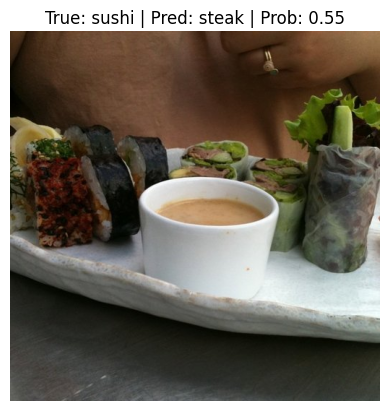

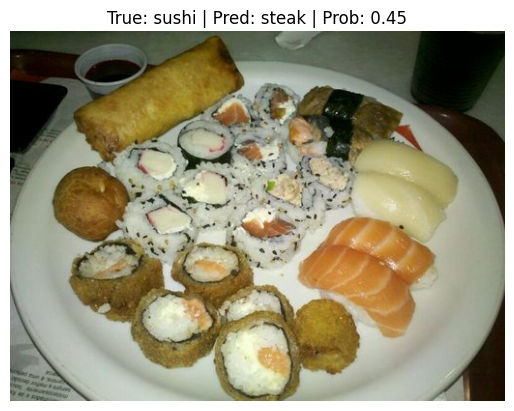

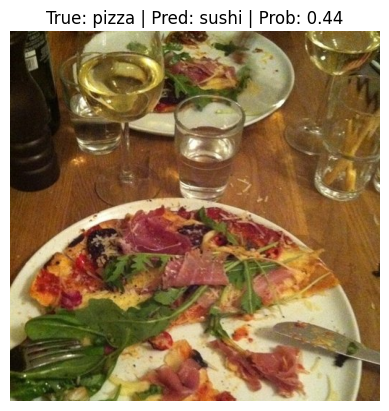

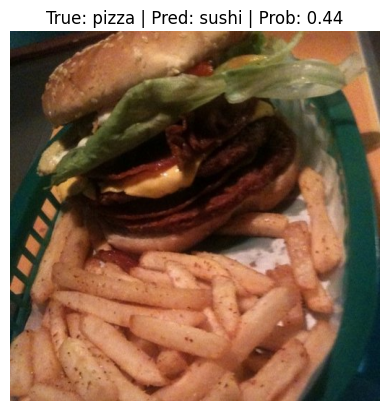

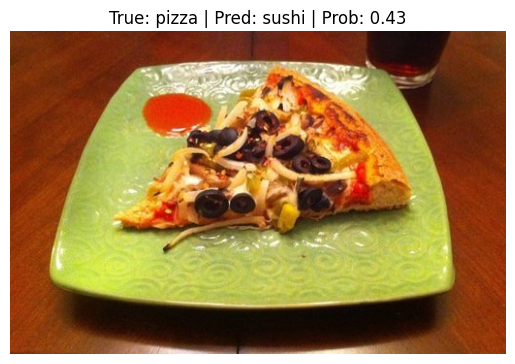

In [19]:
# Plot more wrong
import matplotlib.pyplot as plt

for row in top_5_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]

  img = torchvision.io.read_image(str(image_path))
  plt.figure()
  plt.imshow(img.permute(1,2,0))
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.2f}")
  plt.axis(False);

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [20]:
# Download the image
!wget https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
!cp photo-1588315029754-2dd089d39a1a pizza.jpg

# Set the image path
sushi_image_path = "/content/pizza.jpg"


--2025-07-10 13:54:41--  https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3208960 (3.1M) [image/jpeg]
Saving to: ‘photo-1588315029754-2dd089d39a1a’

photo-1588315029754 100%[===================>]   3.06M  --.-KB/s    in 0.06s   

2025-07-10 13:54:41 (53.9 MB/s) - ‘photo-1588315029754-2dd089d39a1a’ saved [3208960/3208960]



In [21]:
from typing import List, Tuple
from PIL import Image

#Make a function to predict and plot images
def pred_and_plot(model: torch.nn.Module,
                  image_path: str,
                  class_names:List[str],
                  transform: torchvision.transforms,
                  device: torch.device = device):
  # Open image
  img = Image.open(image_path)

  # Transform image
  transformed_image = transform(img).unsqueeze(0).to(device)

  # Make sure model is on target device
  model.to(device)

  # Predict on image
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image)
    pred_label = torch.argmax(torch.softmax(pred_logit, dim =1), dim = 1)

  # Plot image and pred
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[pred_label]}")
  plt.axis(False);

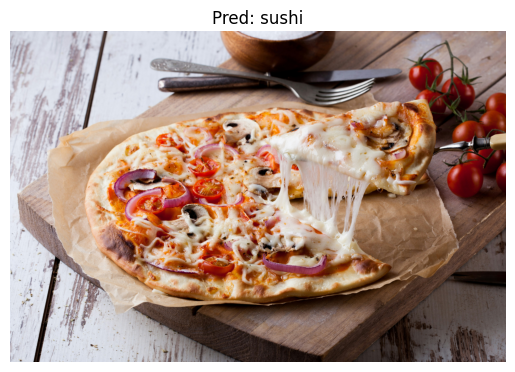

In [22]:
pred_and_plot(image_path=sushi_image_path,
              model = model_0,
              transform= simple_transform,
              class_names= class_names)

--2025-07-10 13:54:49--  https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2006529 (1.9M) [image/jpeg]
Saving to: ‘photo-1570913149827-d2ac84ab3f9a’

photo-1570913149827 100%[===================>]   1.91M  --.-KB/s    in 0.05s   

2025-07-10 13:54:49 (40.6 MB/s) - ‘photo-1570913149827-d2ac84ab3f9a’ saved [2006529/2006529]



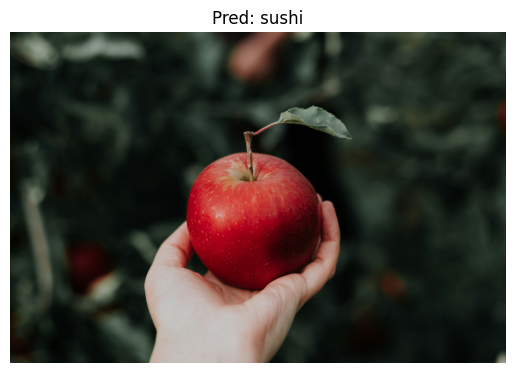

In [23]:
# TODO: Get an image of not pizza/steak/sushi
!wget https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
!cp photo-1570913149827-d2ac84ab3f9a apple.jpg

# Set the image path
sushi_image_path = "/content/apple.jpg"

# Pred the image
pred_and_plot(image_path= "apple.jpg",
              model= model_0,
              transform = simple_transform,
              class_names= class_names)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [24]:
# TODO: Recreate a new model
# Set up the model with pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights= weights).to(device)

In [25]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_1,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [26]:
# Freeze all base layer
for param in model_1.features.parameters():
  param.requires_grad = False

# Recreate the classifier layer
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace = True),
    torch.nn.Linear(in_features= 1280, out_features= len(class_names), bias = True).to(device)
)

In [27]:
# TODO: Train the model for 10 epochs
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr = 0.01)

# Set seed
torch.cuda.manual_seed(42)
torch.manual_seed(42)

# Setup traning and save results
model_1_results = engine.train(model = model_1,
                               train_dataloader = train_dataloader,
                               test_dataloader = test_dataloader,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = 10,
                               device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8340 | train_acc: 0.6289 | test_loss: 0.4250 | test_acc: 0.8456
Epoch: 2 | train_loss: 0.6295 | train_acc: 0.7070 | test_loss: 0.3221 | test_acc: 0.8968
Epoch: 3 | train_loss: 0.2798 | train_acc: 0.9102 | test_loss: 0.2770 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.3641 | train_acc: 0.8359 | test_loss: 0.2452 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.5776 | train_acc: 0.7734 | test_loss: 0.3667 | test_acc: 0.8759
Epoch: 6 | train_loss: 0.7293 | train_acc: 0.8359 | test_loss: 0.3093 | test_acc: 0.8343
Epoch: 7 | train_loss: 0.1217 | train_acc: 0.9688 | test_loss: 0.2848 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.6115 | train_acc: 0.7891 | test_loss: 0.2997 | test_acc: 0.9072
Epoch: 9 | train_loss: 0.6668 | train_acc: 0.8320 | test_loss: 0.3268 | test_acc: 0.8655
Epoch: 10 | train_loss: 0.8529 | train_acc: 0.7539 | test_loss: 0.2868 | test_acc: 0.8759


## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [28]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [29]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [30]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ec963774610>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [31]:
# TODO
# Get pretrained weights and model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b0(weights= weights).to(device)

# Freeze all base layers
for param in model_2.features.parameters():
  param.requires_grad = False

# Change the classifier layer to satified our necessities
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace = True),
    torch.nn.Linear(in_features = 1280, out_features= len(class_names), bias = True).to(device)
)


### Train a model with 20% of the data

In [32]:
# TODO
# Define loss function and optmizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters(), lr = 0.001)

# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2_results = engine.train(model = model_2,
                               train_dataloader = train_dataloader_20_percent,
                               test_dataloader = test_dataloader_20_percent,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = 5,
                               device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9901 | train_acc: 0.5333 | test_loss: 0.6995 | test_acc: 0.8761
Epoch: 2 | train_loss: 0.6953 | train_acc: 0.8375 | test_loss: 0.5377 | test_acc: 0.9097
Epoch: 3 | train_loss: 0.5778 | train_acc: 0.8729 | test_loss: 0.4563 | test_acc: 0.9034
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.8833 | test_loss: 0.4128 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.4435 | train_acc: 0.8917 | test_loss: 0.3777 | test_acc: 0.9222


## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [34]:
# TODO
# Get weights for model
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()

# Create training and testing DataLoaders with that transformr
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = test_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transforms,
                                                                               batch_size = 32)

In [35]:
auto_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [36]:
# Get the model
model_3 = torchvision.models.efficientnet_b2(weights = weights)

# Print summary
summary(model = model_3,
        input_size=(32, 3, 288, 288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"] )

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 155MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 288, 288]    [32, 1408, 9, 9]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    [32, 32, 144, 144]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    [32, 32, 144, 144]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   [32, 32, 144, 144]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   [32, 16, 144

In [39]:
# Freeze base layers
for param in model_3.features.parameters():
  param.requires_grad = False

# Print classifier to know parameters
#print(model_3.classifier)

# Change classifier

model_3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace= True),
    torch.nn.Linear(in_features=1408, out_features=len(class_names), bias= True)
)

In [41]:
### Train the model
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr = 0.001)

# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Move model to device
model_3 = model_3.to(device)

# Get results
model_3_results = engine.train(model = model_3,
                               train_dataloader = train_dataloader,
                               test_dataloader = test_dataloader,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = 5,
                               device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1035 | train_acc: 0.3305 | test_loss: 0.9296 | test_acc: 0.6146
Epoch: 2 | train_loss: 0.9451 | train_acc: 0.6894 | test_loss: 0.8318 | test_acc: 0.7604
Epoch: 3 | train_loss: 0.8734 | train_acc: 0.6297 | test_loss: 0.7330 | test_acc: 0.8229
Epoch: 4 | train_loss: 0.7849 | train_acc: 0.7320 | test_loss: 0.6466 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.7564 | train_acc: 0.7443 | test_loss: 0.5799 | test_acc: 0.9479
